In [130]:
# A simple notebook demonstrating how to extract an attention map from DinoV2 inference (with registers) 

# Most of the core code was originally published here:
#  https://gitlab.com/ziegleto-machine-learning/dino/-/tree/main/

# November 11th, 2023 by Lance Legel (lance@3co.ai) from 3co, Inc. (https://3co.ai)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from dinov2.models.vision_transformer import vit_small, vit_base, vit_large
from matplotlib.colors import Normalize
from io import BytesIO
import requests

In [132]:
# These are settings for ensuring input images to DinoV2 are properly sized

class ResizeAndPad:
    def __init__(self, target_size, multiple):
        self.target_size = target_size
        self.multiple = multiple

    def __call__(self, img):
        # Resize the image
        img = transforms.Resize(self.target_size)(img)

        # Calculate padding
        pad_width = (self.multiple - img.width % self.multiple) % self.multiple
        pad_height = (self.multiple - img.height % self.multiple) % self.multiple

        # Apply padding
        img = transforms.Pad((pad_width // 2, pad_height // 2, pad_width - pad_width // 2, pad_height - pad_height // 2))(img)
        
        return img

image_dimension = 952
    
# This is what DinoV2 sees
target_size = (image_dimension, image_dimension)

# During inference / testing / deployment, we want to remove data augmentations from the input transform:
data_transforms = transforms.Compose([ ResizeAndPad(target_size, 14),
                                       transforms.CenterCrop(image_dimension),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     ]
                                     )

In [133]:
image_size = (image_dimension, image_dimension)
output_dir = '.'
patch_size = 14
n_register_tokens = 4

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = vit_small(
        patch_size=14,
        img_size=526,
        init_values=1.0,
        num_register_tokens=n_register_tokens,
        block_chunks=0
)

# def vit_small(patch_size=16, num_register_tokens=0, **kwargs):
#     model = DinoVisionTransformer(
#         patch_size=patch_size,
#         embed_dim=384,
#         depth=12,
#         num_heads=6,
#         mlp_ratio=4,
#         block_fn=partial(Block, attn_class=MemEffAttention),
#         num_register_tokens=num_register_tokens,
#         **kwargs,
#     )

model.load_state_dict(torch.load('dinov2_vits14_reg4_pretrain.pth'))
for p in model.parameters():
    p.requires_grad = False
model.to(device)
model.eval()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

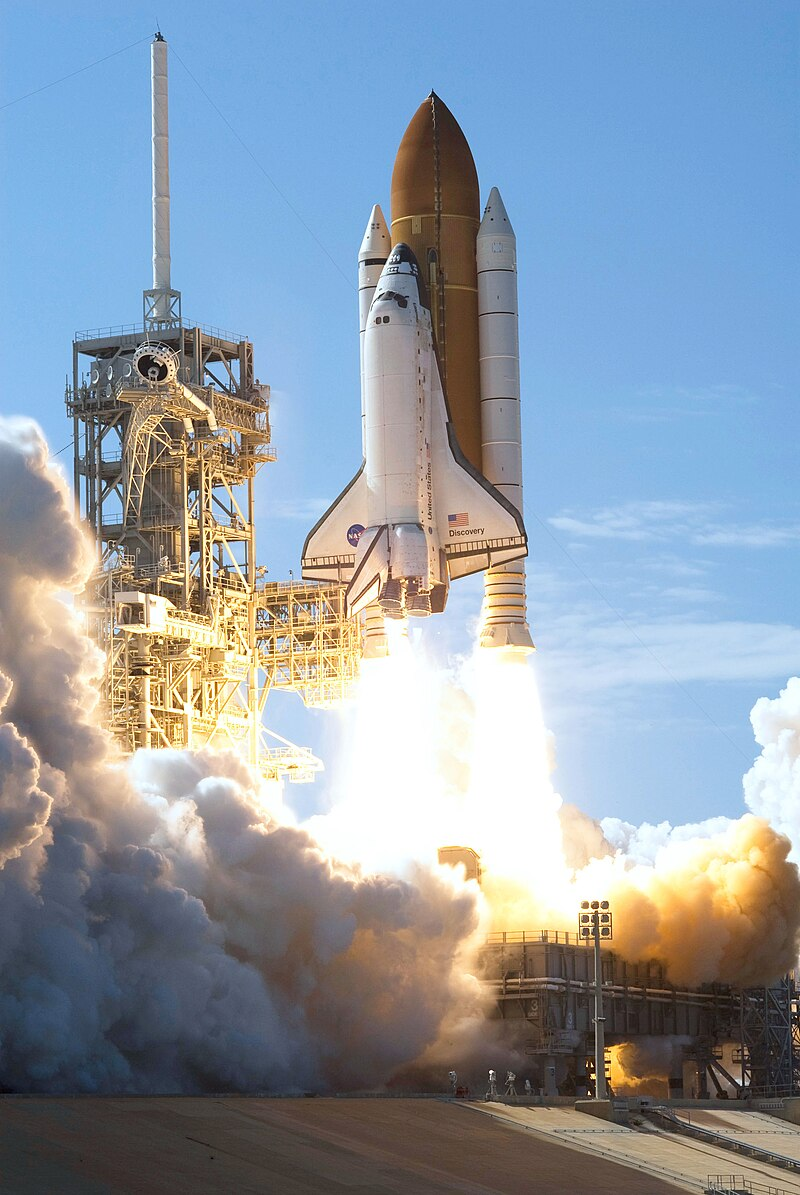

In [134]:
# Load the image (STS-124_launch_from_a_distance.jpg) from path
original_image = Image.open('STS-124_launch_from_a_distance.jpg')

(original_w, original_h) = original_image.size

img = data_transforms(original_image)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h]

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

img = img.unsqueeze(0)
img = img.to(device)

display(original_image)

In [135]:
ret = model.forward(img.to(device), is_training=True, output_attentions=True)
attentions = ret['attentions']
len(attentions)

AttributeError: 'tuple' object has no attribute 'shape'

In [122]:
attention = attentions[-1]
attention.shape

torch.Size([1, 6, 4629, 4629])

In [123]:
number_of_heads = attention.shape[1]

# attention tokens are packed in after the first token; the spatial tokens follow
attention = attention[0, :, 0, 1 + n_register_tokens:].reshape(number_of_heads, -1)
attention.shape

torch.Size([6, 4624])

In [124]:
# resolution of attention from transformer tokens
attention = attention.reshape(number_of_heads, w_featmap, h_featmap)
print(attention.shape)

torch.Size([6, 68, 68])


In [125]:
# upscale to higher resolution closer to original image
attention = nn.functional.interpolate(attention.unsqueeze(0), scale_factor=patch_size, mode = "nearest")[0].cpu()
print(attention.shape)

torch.Size([6, 952, 952])


In [126]:
# sum all attention across the 12 different heads, to get one map of attention across entire image
attention = torch.sum(attention, dim=0)
print(attention.shape)

torch.Size([952, 952])


In [127]:
# interpolate attention map back into original image dimensions
attention_of_image = nn.functional.interpolate(attention.unsqueeze(0).unsqueeze(0), size=(original_h, original_w), mode='bilinear', align_corners=False)
attention_of_image = attention_of_image.squeeze()
print(attention_of_image.shape)

torch.Size([1195, 800])


In [128]:
# Normalize image_metric to the range [0, 1]
image_metric = attention_of_image.numpy()
normalized_metric = Normalize(vmin=image_metric.min(), vmax=image_metric.max())(image_metric)

# Apply the Reds colormap
reds = plt.cm.Reds(normalized_metric)

# Create the alpha channel
alpha_max_value = 1.00  # Set your max alpha value

# Adjust this value as needed to enhance lower values visibility
gamma = 0.5  

# Apply gamma transformation to enhance lower values
enhanced_metric = np.power(normalized_metric, gamma)

# Create the alpha channel with enhanced visibility for lower values
alpha_channel = enhanced_metric * alpha_max_value

# Add the alpha channel to the RGB data
rgba_mask = np.zeros((image_metric.shape[0], image_metric.shape[1], 4))
rgba_mask[..., :3] = reds[..., :3]  # RGB
rgba_mask[..., 3] = alpha_channel  # Alpha

# Convert the numpy array to PIL Image
rgba_image = Image.fromarray((rgba_mask * 255).astype(np.uint8))

# Save the image
rgba_image.save('attention_mask.png')

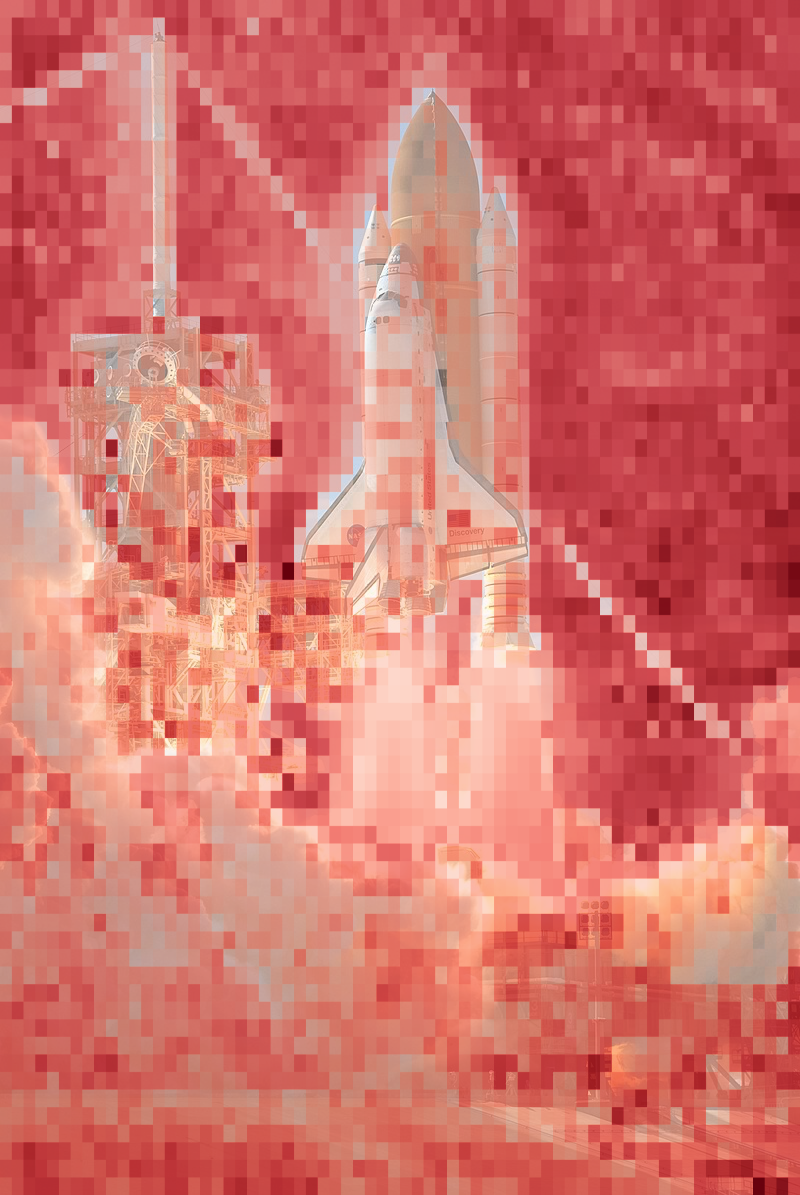

In [129]:
# Load the attention mask with PIL
attention_mask_image = Image.open("{}/attention_mask.png".format(output_dir))
# reload the original image
original_image = Image.open('STS-124_launch_from_a_distance.jpg')

# Ensure both images are in the same mode
if original_image.mode != 'RGBA':
    original_image = original_image.convert('RGBA')

# Overlay the second image onto the first image
# The second image must be the same size as the first image
original_image.paste(attention_mask_image, (0, 0), attention_mask_image)

# Save or show the combined image
original_image.save('image_with_attention.png')

# Or display it
display(original_image)